This is a step by step implementation of the Stroke Width transform paper which describes the way to detect text in natural scenes

[Detecting Text in Natural Scenes with
Stroke Width Transform](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/1509.pdf)

In [1]:
from skimage.io import imread
from skimage.filters import gaussian
import matplotlib.pyplot as plt

image = gaussian(imread('resources/sign.jpeg'))
plt.imshow(image)
plt.show()

/Users/muthukrishnan/Library/Python/3.7/lib/python/site-packages/skimage/filters/_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


<Figure size 640x480 with 1 Axes>

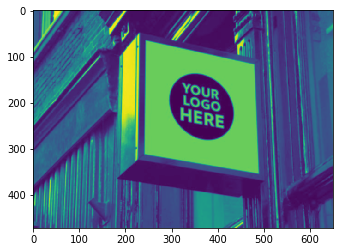

In [2]:
#step 1 : color to gray
from skimage import feature
from skimage.color import rgb2gray

image = rgb2gray(image)
plt.imshow(image)

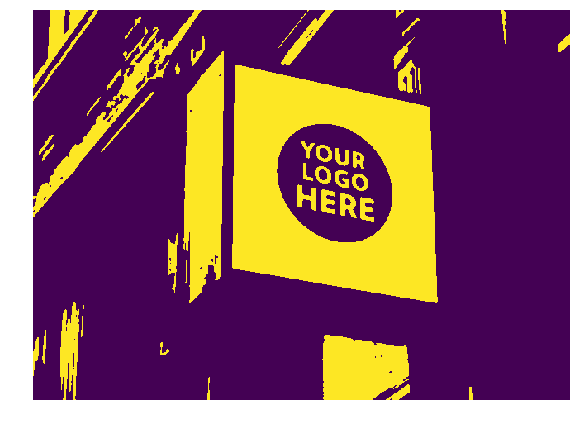

In [3]:
#step 2: binarize and remove regions which most probably not have text
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
import matplotlib.patches as mpatches
from skimage.morphology import convex_hull_image

thresh = threshold_otsu(image)
binary = image > thresh


REGION_AREA_THRESHOLD = 0.75

def is_the_region_too_big(region_area, image_area):
    return region_area > image_area * REGION_AREA_THRESHOLD

def remove_non_digit_noise(binary_image):
    label_image = label(binary_image, connectivity=2)
    height, width = binary_image.shape
    img_area = width * height
    roi_column = [int(width * 0.2), int(width * 0.8)]
    roi_row = [int(height * 0.2), int(height * 0.8)]

    for region in regionprops(label_image):
        minr, minc, maxr, maxc = region.bbox
        w = maxc - minc
        h = maxr - minr
        region_area = w * h

        asr = w / h
        # The size of the region should be greater than 2% of the image
        if asr < 0.1 or len(region.coords) < 50 or \
                is_the_region_too_big(region.area, img_area):
            for region_coord in region.coords:
                binary_image[region_coord[0]][region_coord[1]] = False

    return binary_image

regions_with_text = remove_non_digit_noise(binary)
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(regions_with_text)
ax.set_axis_off()
plt.tight_layout()
plt.show()

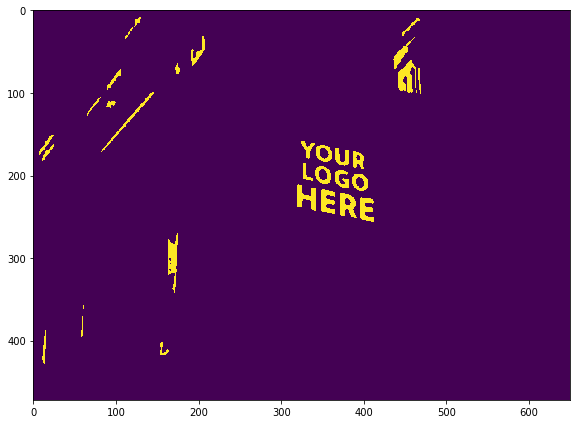

In [4]:
# further clean the image to remove outlier regions
from scipy.ndimage.morphology import distance_transform_edt
from scipy import stats
import numpy as np
from skimage.segmentation import clear_border

def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((ys > upper_bound) | (ys < lower_bound))

swt_input = clear_border(np.copy(regions_with_text))
label_image = label(swt_input, connectivity=2)

stroke_widths = []
regions_coords = []
for region in regionprops(label_image):
    regions_coords.append(region.coords)
    distances = distance_transform_edt(region.coords)
    median_distance = np.median(distances[distances>1])
    stroke_widths.append(median_distance)

outliers_indexes = outliers_iqr(stroke_widths)
outlier_regions = np.array(regions_coords)[outliers_indexes]
for region in outlier_regions:
    for region_coord in region:
        swt_input[region_coord[0]][region_coord[1]] = False
        
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(swt_input)
plt.tight_layout()
plt.show()

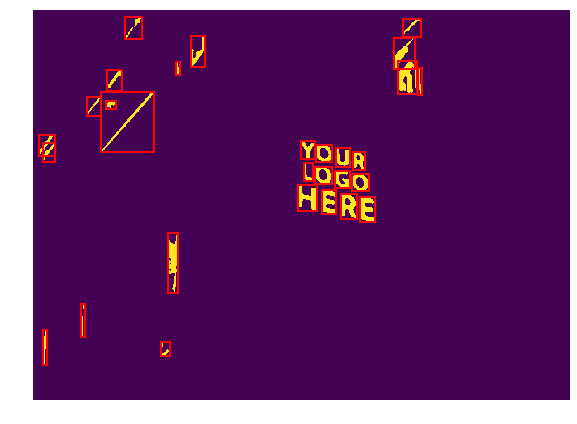

In [5]:
from scipy.spatial.distance import euclidean

label_image = label(swt_input, connectivity=2)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(swt_input)

def get_region_height_width(region):
    minr, minc, maxr, maxc = region.bbox
    region_height = maxr - minr
    region_width = maxc - minc
    return region_width, region_height

centroids = []
regions = []

for region in regionprops(label_image):
    regions.append(region)
    centroids.append(region.centroid)
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

[1 2 1 2 2 1 2 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 4 3 3 4]
number of estimated clusters : 5


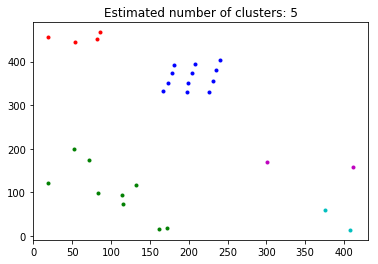

In [6]:
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets import make_blobs

# #############################################################################
# Generate sample data
X = np.array(centroids)

# #############################################################################
# Compute clustering with MeanShift

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(X, quantile=0.2)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
print(labels)
n_clusters_ = len(np.unique(labels))

print("number of estimated clusters : %d" % n_clusters_)

# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()